In [6]:
import pandas as pd
import numpy as np
import os
sep=os.sep
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import copy
from sklearn import svm
import seaborn as sns
import glob

In [15]:
base = 'test/output/remote/simulatorRun/'
base_pth_sc = base + sep + 'fsv_quick'
base_pth_pt = base + sep + 'fsv_quick'

In [16]:
stopped_sc = []
for f in os.listdir(base_pth_sc):
    if 'test' in f:
        continue
    log = json.loads(open(base_pth_sc+os.sep+f+os.sep+'logs.json').read())
    e = log['best_val_epoch']
    stopped_sc.append(e)

In [19]:
stopped_pt = []
for f in os.listdir(base_pth_sc):
    if 'test' in f:
        continue
    log = json.loads(open(base_pth_sc+os.sep+f+os.sep+'logs.json').read())
    e = log['best_val_epoch']
    stopped_pt.append(e)

In [22]:
data = np.array([stopped_sc, stopped_pt])
data = np.rollaxis(data, 1, 0)

In [23]:
df_ep = pd.DataFrame(data=data, columns=['From scratch', 'Pretrained'])

In [41]:
EPOCH = [['Experiment', 'Stopped on epoch']]
SCORE = [['Experiment','Score','Value']]
for fold in range(10):
    path_sc = base_pth_sc + sep + f'fold_{fold}' + sep + 'test_metrics.csv'
    path_pt = base_pth_pt + sep + f'fold_{fold}' + sep + 'test_metrics.csv'
    
    line_sc = open(path_sc).readlines()[1].split(',')
    a_sc, f1_sc = float(line_sc[1]), float(line_sc[2])
    SCORE.append(['Acc. from scratch', 'Accuracy', a_sc])
    SCORE.append(['Acc. from scratch', 'F1', f1_sc])
    
    line_pt = open(path_pt).readlines()[1].split(',')
    a_pt, f1_pt = float(line_pt[1]), float(line_pt[2])
    SCORE.append(['Acc. with pre-training', 'Accuracy', a_pt])
    SCORE.append(['Acc. with pre-training', 'F1', f1_pt])
    
    log_sc = json.loads(open(base_pth_sc+sep+f'fold_{fold}' + sep + 'logs.json').read())
    log_pt = json.loads(open(base_pth_pt+sep+f'fold_{fold}' + sep + 'logs.json').read())
    
    EPOCH.append(['Convergence from scratch.', log_sc['best_val_epoch']])
    EPOCH.append(['Convergence with pre-training.', log_pt['best_val_epoch']])

In [25]:
df = pd.DataFrame(SCORE[1:], columns=SCORE[0])

In [26]:
plt.rcParams['figure.figsize'] = 16, 10
sns.set_context("talk")

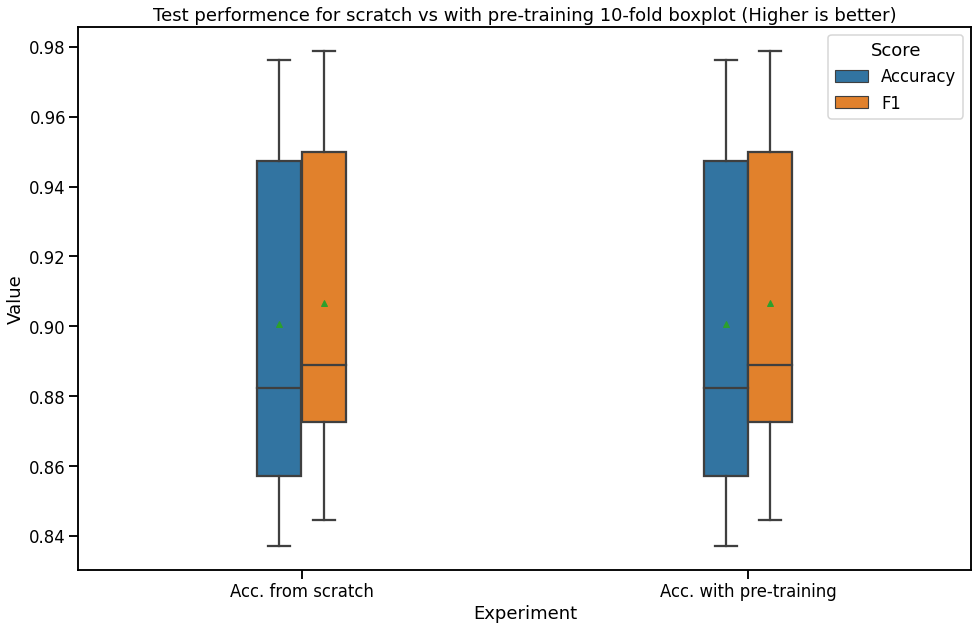

In [27]:
plt.title('Test performence for scratch vs with pre-training 10-fold boxplot (Higher is better)')
ax = sns.boxplot(x='Experiment', y='Value', hue='Score', data=df, width=0.2, showmeans=True)
plt.savefig('assets/perf_box.png')

In [28]:
df_ep = pd.DataFrame(EPOCH[1:], columns=EPOCH[0])

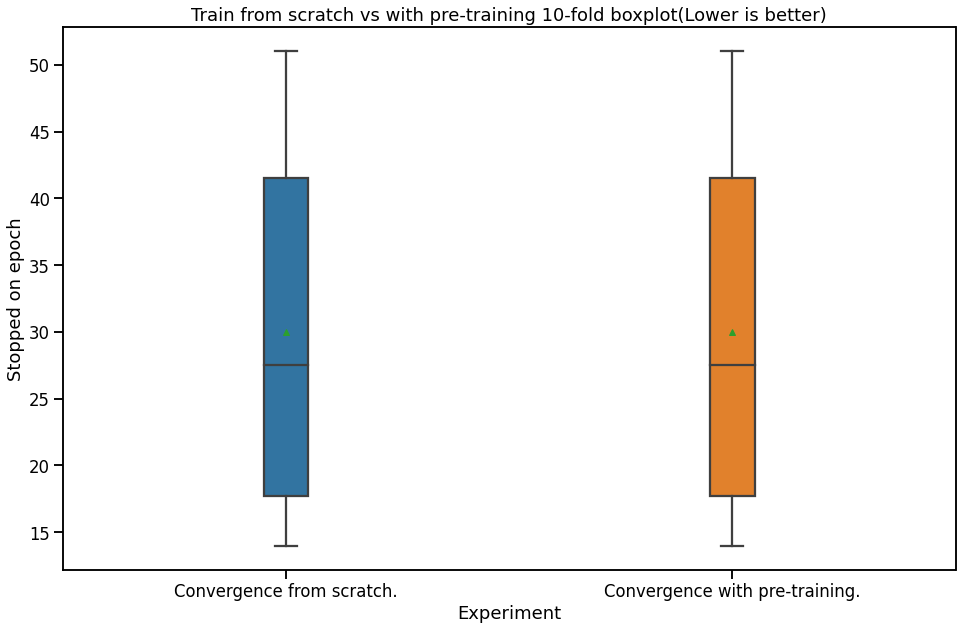

In [29]:
plt.title('Train from scratch vs with pre-training 10-fold boxplot(Lower is better)')
ax = sns.boxplot(x='Experiment', y='Stopped on epoch', data=df_ep, width=0.1, showmeans=True)
plt.savefig('assets/pretrain_box.png')

In [42]:
'Mean stopping epochs', 68.5, 42.7,30

('Mean stopping epochs', 68.5, 42.7, 30)

In [6]:
vals = []
for i in os.listdir('pooled_logs/'):
    if 'fold' not in i: continue
    file = json.loads(open(f'pooled_logs/{i}/logs.json').read())
    vals.append(file['best_val_epoch'])

In [7]:
sum(vals)/len(vals)

11.4

In [31]:
1 hour 30 minutes.

SyntaxError: invalid syntax (<ipython-input-31-72a92642bdf9>, line 1)

In [37]:
eps = [e[-1] for e in EPOCH[1:]]

In [38]:
sum(eps)/len(eps)

30.0

In [1]:
import pandas as pd

In [8]:
cov = {
      "value": {
        "subject0_aseg_stats.txt": {
          "isControl": "False",
          "age": "22.0"
        },
        "subject1_aseg_stats.txt": {
          "isControl": "True",
          "age": "47.0"
        },
        "subject2_aseg_stats.txt": {
          "isControl": "False",
          "age": "56.0"
        },
        "subject3_aseg_stats.txt": {
          "isControl": "True",
          "age": "73.0"
        },
        "subject4_aseg_stats.txt": {
          "isControl": "False",
          "age": "58.0"
        },
        "subject5_aseg_stats.txt": {
          "isControl": "False",
          "age": "67.0"
        },
        "subject6_aseg_stats.txt": {
          "isControl": "False",
          "age": "40.0"
        },
        "subject7_aseg_stats.txt": {
          "isControl": "True",
          "age": "25.0"
        },
        "subject8_aseg_stats.txt": {
          "isControl": "True",
          "age": "51.0"
        },
        "subject9_aseg_stats.txt": {
          "isControl": "False",
          "age": "37.0"
        },
        "subject10_aseg_stats.txt": {
          "isControl": "False",
          "age": "35.0"
        },
        "subject11_aseg_stats.txt": {
          "isControl": "False",
          "age": "29.0"
        },
        "subject12_aseg_stats.txt": {
          "isControl": "False",
          "age": "33.0"
        },
        "subject13_aseg_stats.txt": {
          "isControl": "False",
          "age": "21.0"
        },
        "subject14_aseg_stats.txt": {
          "isControl": "False",
          "age": "40.0"
        },
        "subject15_aseg_stats.txt": {
          "isControl": "True",
          "age": "25.0"
        },
        "subject16_aseg_stats.txt": {
          "isControl": "False",
          "age": "23.0"
        },
        "subject17_aseg_stats.txt": {
          "isControl": "True",
          "age": "60.0"
        },
        "subject18_aseg_stats.txt": {
          "isControl": "False",
          "age": "31.0"
        },
        "subject19_aseg_stats.txt": {
          "isControl": "False",
          "age": "60.0"
        },
        "subject20_aseg_stats.txt": {
          "isControl": "False",
          "age": "71.0"
        },
        "subject21_aseg_stats.txt": {
          "isControl": "True",
          "age": "57.0"
        },
        "subject22_aseg_stats.txt": {
          "isControl": "True",
          "age": "38.0"
        },
        "subject23_aseg_stats.txt": {
          "isControl": "True",
          "age": "46.0"
        },
        "subject24_aseg_stats.txt": {
          "isControl": "True",
          "age": "25.0"
        },
        "subject25_aseg_stats.txt": {
          "isControl": "True",
          "age": "40.0"
        },
        "subject26_aseg_stats.txt": {
          "isControl": "False",
          "age": "65.0"
        },
        "subject27_aseg_stats.txt": {
          "isControl": "False",
          "age": "33.0"
        },
        "subject28_aseg_stats.txt": {
          "isControl": "False",
          "age": "49.0"
        },
        "subject29_aseg_stats.txt": {
          "isControl": "True",
          "age": "30.0"
        },
        "subject30_aseg_stats.txt": {
          "isControl": "True",
          "age": "23.0"
        },
        "subject31_aseg_stats.txt": {
          "isControl": "False",
          "age": "29.0"
        },
        "subject32_aseg_stats.txt": {
          "isControl": "True",
          "age": "77.0"
        },
        "subject33_aseg_stats.txt": {
          "isControl": "True",
          "age": "44.0"
        },
        "subject34_aseg_stats.txt": {
          "isControl": "True",
          "age": "28.0"
        },
        "subject35_aseg_stats.txt": {
          "isControl": "True",
          "age": "73.0"
        },
        "subject36_aseg_stats.txt": {
          "isControl": "False",
          "age": "35.0"
        },
        "subject37_aseg_stats.txt": {
          "isControl": "True",
          "age": "79.0"
        },
        "subject38_aseg_stats.txt": {
          "isControl": "True",
          "age": "31.0"
        },
        "subject39_aseg_stats.txt": {
          "isControl": "True",
          "age": "80.0"
        },
        "subject40_aseg_stats.txt": {
          "isControl": "False",
          "age": "25.0"
        },
        "subject41_aseg_stats.txt": {
          "isControl": "True",
          "age": "22.0"
        },
        "subject42_aseg_stats.txt": {
          "isControl": "True",
          "age": "49.0"
        },
        "subject43_aseg_stats.txt": {
          "isControl": "False",
          "age": "30.0"
        },
        "subject44_aseg_stats.txt": {
          "isControl": "True",
          "age": "23.0"
        },
        "subject45_aseg_stats.txt": {
          "isControl": "True",
          "age": "27.0"
        },
        "subject46_aseg_stats.txt": {
          "isControl": "False",
          "age": "67.0"
        },
        "subject47_aseg_stats.txt": {
          "isControl": "False",
          "age": "73.0"
        },
        "subject48_aseg_stats.txt": {
          "isControl": "False",
          "age": "38.0"
        },
        "subject49_aseg_stats.txt": {
          "isControl": "False",
          "age": "69.0"
        },
        "subject50_aseg_stats.txt": {
          "isControl": "False",
          "age": "26.0"
        },
        "subject51_aseg_stats.txt": {
          "isControl": "True",
          "age": "33.0"
        },
        "subject52_aseg_stats.txt": {
          "isControl": "False",
          "age": "48.0"
        },
        "subject53_aseg_stats.txt": {
          "isControl": "True",
          "age": "46.0"
        },
        "subject54_aseg_stats.txt": {
          "isControl": "True",
          "age": "70.0"
        },
        "subject55_aseg_stats.txt": {
          "isControl": "True",
          "age": "32.0"
        },
        "subject56_aseg_stats.txt": {
          "isControl": "False",
          "age": "45.0"
        },
        "subject57_aseg_stats.txt": {
          "isControl": "False",
          "age": "33.0"
        },
        "subject58_aseg_stats.txt": {
          "isControl": "False",
          "age": "78.0"
        },
        "subject59_aseg_stats.txt": {
          "isControl": "True",
          "age": "50.0"
        },
        "subject60_aseg_stats.txt": {
          "isControl": "False",
          "age": "33.0"
        },
        "subject61_aseg_stats.txt": {
          "isControl": "False",
          "age": "73.0"
        },
        "subject62_aseg_stats.txt": {
          "isControl": "True",
          "age": "69.0"
        },
        "subject63_aseg_stats.txt": {
          "isControl": "False",
          "age": "31.0"
        },
        "subject64_aseg_stats.txt": {
          "isControl": "True",
          "age": "74.0"
        },
        "subject65_aseg_stats.txt": {
          "isControl": "True",
          "age": "53.0"
        },
        "subject66_aseg_stats.txt": {
          "isControl": "True",
          "age": "43.0"
        },
        "subject67_aseg_stats.txt": {
          "isControl": "True",
          "age": "25.0"
        },
        "subject68_aseg_stats.txt": {
          "isControl": "False",
          "age": "61.0"
        },
        "subject69_aseg_stats.txt": {
          "isControl": "True",
          "age": "74.0"
        },
        "subject70_aseg_stats.txt": {
          "isControl": "False",
          "age": "68.0"
        },
        "subject71_aseg_stats.txt": {
          "isControl": "True",
          "age": "54.0"
        },
        "subject72_aseg_stats.txt": {
          "isControl": "False",
          "age": "74.0"
        }
      }
    }

In [23]:
df = pd.DataFrame.from_dict(cov['value'])

In [24]:
df.T

,isControl,age
subject0_aseg_stats.txt,False,22.0
subject1_aseg_stats.txt,True,47.0
subject2_aseg_stats.txt,False,56.0
subject3_aseg_stats.txt,True,73.0
subject4_aseg_stats.txt,False,58.0
...,...,...
subject68_aseg_stats.txt,False,61.0
subject69_aseg_stats.txt,True,74.0
subject70_aseg_stats.txt,False,68.0
subject71_aseg_stats.txt,True,54.0


In [82]:
json.load(open('test.json'))

{'One': None, 'two': 2}

In [22]:
import pickle
import json
import copy
from torch.utils.data import DataLoader, Dataset

In [24]:
class D(Dataset):
    def __init__(self):
        self.data = list(range(100))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, ix):
        return self.data[ix]

In [25]:
d = D()

In [26]:
l = DataLoader(dataset=d)

In [42]:
a = {'b': {'b1':1, 'c':{'c1'}}}

In [43]:
c = copy.deepcopy(a)

In [44]:
c['b']['c'] = 1111